# Ghana Drone Images Chipping Pipeline

This notebook is for chipping the existing Ghana Drone Images. The chipping pipeline is based on the existing code from Lyndon Estes and Sam Khallaghi. The original drone image data is from a existing project by Clark University and Farmerline and this pipeline helps to chip the existing tile data into chips for training purposes.

## Imports

In [1]:
# importing necessary modules
import os
import sys
import importlib

In [2]:
# Specify the path to the package
current_pth = os.getcwd()
pkg_path = os.path.dirname(current_pth)

In [3]:
# Adding the path to the package to the system path
sys.path.insert(0, os.path.join(pkg_path, 'imageProcessing/'))
sys.path.insert(0, pkg_path)

In [4]:
# Importing the imageProcessing package
import imageProcessing
importlib.reload(imageProcessing)
from imageProcessing import *

## Config

In [5]:

# Specify the path to the project directory
# This would be the directory that you clone the repo into
proj_dir = Path("/Volumes/sTeeeve/GIS_Data/Ghana_Drone_Images/")

# Configureation parameters
config = {
    
    #I/O and path setup

    # Path to the project directory
    "proj_dir" : Path("/Volumes/sTeeeve/GIS_Data/Ghana_Drone_Images/"), 
    # Path to the label file
    "label_path" : Path("/Volumes/sTeeeve/GIS_Data/Ghana_Drone_Images/labels/class2_all_fix_v1_2.geojson"), 
    # Path to the bounding box file
    "labelled_area_path" : Path("/Volumes/sTeeeve/GIS_Data/Ghana_Drone_Images/labels/ortho_exts_maingrid_rectified_v1_1.geojson"), 
    # Path to the raw image directory
    "img_dir" : Path(proj_dir) / "processed",
    # Path to save the rasterized image tiles
    "img_out_dir" : Path(proj_dir) / "working/image_tiles",
    # Path to save the rasterized label tiles
    "lbl_out_dir" : Path(proj_dir) / "working/label_tiles",
    # Path to save the rasterized mask tiles
    "msk_out_dir" : Path(proj_dir) / "working/mask_tiles",
    # Path to save the processed image chips
    "lbl_chip_dir" : Path(proj_dir) / "label_chips",
    # Path to save the processed label chips
    "img_chip_dir" : Path(proj_dir) / "image_chips",

    # Image processing parameters
    "prim_crop" : ['maize', 'rice'], # When doing binary crop classification only specify one crop here The donimate crop are maize and rice.
    "binary_mask" : False,           # If True, will create a binary mask for crop and non-crop

    # Output format for the image chips. Geotiff, npz and pkl are available.
    # If npz or pkl, the image chips will be saved along the label chips as pairs in a list
    # Two files that contians the training and validation chips will be created.
    # When no output format is specified, the default is tif and will be saved to the provided path.
    "output_format" : "tif",         

    "positive_threshold" : 0.1,      # Threshold for the positive class in the mask, between 0 and 1

    # output resolution for images. original was 2.5e-07
    # res = 10e-07 is used in this example and as default.
    # Warning: Using the res option might result in tiles with different sizes(nrows, ncols)
    "res": 10e-07,                

    # When res is not used, the number of rows and columns in each tile must be specified
    "nrows": 5000,                  # number of rows in each tile
    "ncols": 5000,                  # number of columns in each tile

    "tile_size" : 256,              # tile size in pixels
    "overlap": 32,                  # overlap between tiles in pixels

}

# Create the output directories if they don't exist
dir_list = [config["img_out_dir"], config["lbl_out_dir"], config["msk_out_dir"], config["img_chip_dir"], config["lbl_chip_dir"]]
for folder in dir_list:
    if not os.path.isdir(folder):
        os.makedirs(folder)

## Checking/Loading Label Information

In [6]:
# Loading the bounding box for the labelled area
bbox = gpd.read_file(config["labelled_area_path"])
bbox.head()

,grid_name,region,cid,sid,file_name,geometry
0,GH0484825,ej,1426,388,GH0484825.tif,"POLYGON ((-0.99600 7.20000, -0.99100 7.20000, ..."
1,GH0486273,ej,1435,12,GH0486273.tif,"POLYGON ((-0.98600 7.19000, -0.98100 7.19000, ..."
2,GH0358883,ej,909,44,GH0358883.tif,"POLYGON ((-2.36100 8.11000, -2.35600 8.11000, ..."
3,GH0373226,ej,932,296,GH0373226.tif,"POLYGON ((-1.59100 8.00000, -1.58600 8.00000, ..."
4,GH0419907,ej,1088,138,GH0419907.tif,"POLYGON ((-1.08600 7.66000, -1.08100 7.66000, ..."


In [7]:
# Loading the labels for each image tile
labels = gpd.read_file(config["label_path"])
labels.head()

,region,grid_name,id,fixed,regiorth,cid,sid,file_name,labeller,prim_crop,sec_crop,confidence,notes,geometry
0,,GH0004386,D1,0.0,north63,402,42,GH0004386.tif,labeller2,fallow,None,high,None,"POLYGON ((-0.31889 10.98019, -0.31880 10.98016..."
1,ej,GH0353750,D6027,0.0,ej2,909,7,GH0353750.tif,labeller4,yam,None,High,None,"POLYGON ((-2.34586 8.14466, -2.34529 8.14451, ..."
2,ej,GH0353750,D6028,0.0,ej2,909,7,GH0353750.tif,labeller4,fallow,None,LOw,None,"POLYGON ((-2.34388 8.14620, -2.34401 8.14585, ..."
3,ej,GH0353750,D6029,0.0,ej2,909,7,GH0353750.tif,labeller4,fallow,None,High,None,"POLYGON ((-2.34505 8.15008, -2.34496 8.15021, ..."
4,ej,GH0353750,D6030,0.0,ej2,909,7,GH0353750.tif,labeller4,fallow,None,High,None,"POLYGON ((-2.34507 8.15022, -2.34462 8.15022, ..."


In [8]:
# Filtering the tables to only include necessary information

labels = labels[["grid_name", "prim_crop", "confidence", "file_name", "geometry"]]
bbox = bbox[["grid_name", "file_name", "geometry"]]

# Gather the list of path of all the image tiles in the image directory
img_paths = list_full_path(config["img_dir"], ".tif$")

## Chipping Process

In [9]:
# Creating image, mask and label rasters
img_list, lbl_list, msk_list = create_msk_lbl_img(img_paths[0:3], labels, bbox, 
                                                  proj_dir,config["msk_out_dir"], 
                                                  config["lbl_out_dir"], 
                                                  config["img_out_dir"],
                                                  res=None,
                                                  nrow=config["nrows"],
                                                  ncol=config["ncols"],
                                                  binary_mask=config["binary_mask"], 
                                                  prim_crop=config["prim_crop"])

100%|██████████| 3/3 [00:25<00:00,  8.57s/it]


In [10]:
# Splitting the image, mask and label rasters into chips and save the information in a catalog
chipping_catalog = train_test_split_cat(img_list, lbl_list, msk_list, proj_dir)

In [11]:
# Do the chipping based on the catalog and other parameters
chipping(proj_dir, config["lbl_chip_dir"], 
         config["img_chip_dir"], 
         config["output_format"], 
         chipping_cat=chipping_catalog, # Returned from train_test_split_cat
         patch_size=config["tile_size"],
         overlap=config["overlap"],
         positive_class_threshold = config["positive_threshold"])

## Visualize chipped img and lbl pairs

In [12]:
# Loading the catalog of the chipped images and display it
cat = pd.read_csv(Path(proj_dir) / "working" / "chips_catalog.csv")
cat.head()

,Unnamed: 0,name,labels,images,usage
0,0,img_GH0021893.tif,label_chips/label_GH0021893_0.tif,image_chips/img_GH0021893_0.tif,train
1,1,img_GH0021893.tif,label_chips/label_GH0021893_1.tif,image_chips/img_GH0021893_1.tif,train
2,2,img_GH0021893.tif,label_chips/label_GH0021893_2.tif,image_chips/img_GH0021893_2.tif,train
3,3,img_GH0021893.tif,label_chips/label_GH0021893_3.tif,image_chips/img_GH0021893_3.tif,train
4,4,img_GH0021893.tif,label_chips/label_GH0021893_4.tif,image_chips/img_GH0021893_4.tif,train


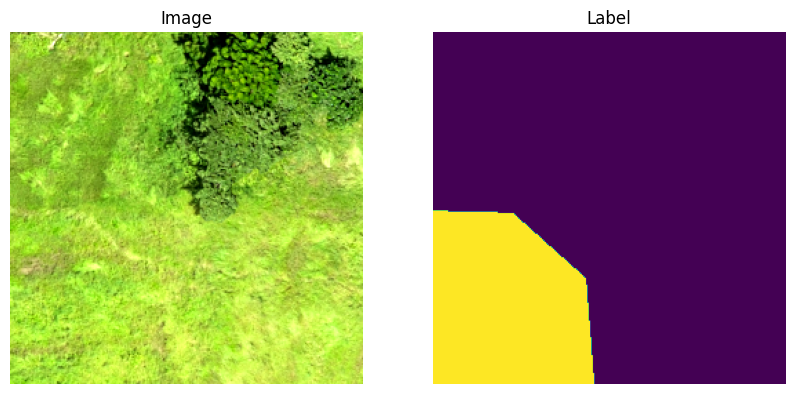

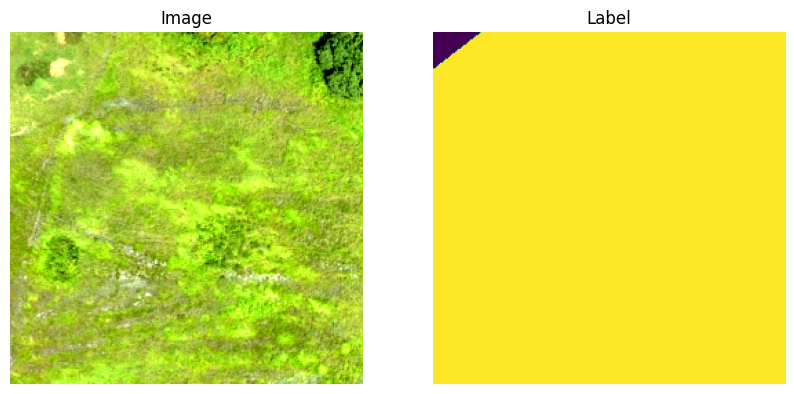

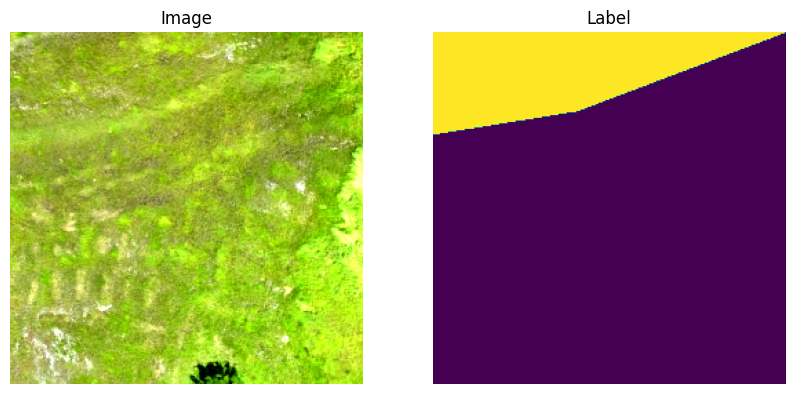

In [17]:
band_composite=[1,2,3] # RGB
stretch = True  
samples = random.sample(range(0, len(cat)), 3) # Randomly select 3 samples from the catalog

# Plotting the image chips and label chips
for sample in samples:
    plot_img_lbl_pair(Path(proj_dir) / cat["images"][sample], Path(proj_dir) / cat["labels"][sample], band_composite, stretch)